# Linear Regression

Regression is used to predict outputs that are *continuous*

*******************************************************************************************************************************
#### Aside: Distance Formula
   For two sets of points $[a_1,a_2]$ and $[b_1,b_2]$ 
* **Euclidean Distance**
    $d = \sqrt{(a_1 - b_1)^2 + (a_2 - b_2)^2}$
* **Manhattan Distance**
    $d = |a_1 - b_1| + |a_2 - b_2|$
* **Hamming Distance**
    Hamming distance tells us how many points are equal, for example: the two strings 'there' and typo 'thete' would have a Hamming distance of 1. We can do this for lists too. Note: both objects must have the same dimensions.
    
There are specific functions in SciPy for calculating these too: distance.euclidean(), distance.cityblock(), distance.hamming()
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
*******************************************************************************************************************************

When we plot a linear regression, each data point has a loss from the *true* value, which measures how bad the model's prediction was. The loss is the *squared distance* from the point to the line. We want to *minimise* the losses, see **Least Squares as Maximum Likelihood Estimator** in **Notes on Statistics & Modelling** (that's essentially whats going on).

To test out using **Linear Regression** I'm going to create a random set of $x$ values and sort it for our linear fit. To generate our 'fake' data we fit $y = mx + b$ and then 'randomise' it by adding *normally distributed noise*. The notation for this is:
$$ D \sim \mathcal{N} \left(M(\theta), \sigma_{obi}^2 \right) $$
$$ M(\theta) = \alpha (mx + b) $$

where $M(\theta)$ is our model, which in this case is *linear*, $\alpha$ represents the **activation**(?).

https://emcee.readthedocs.io/en/stable/tutorials/line/

# Linear Regression Algorithm from Scratch

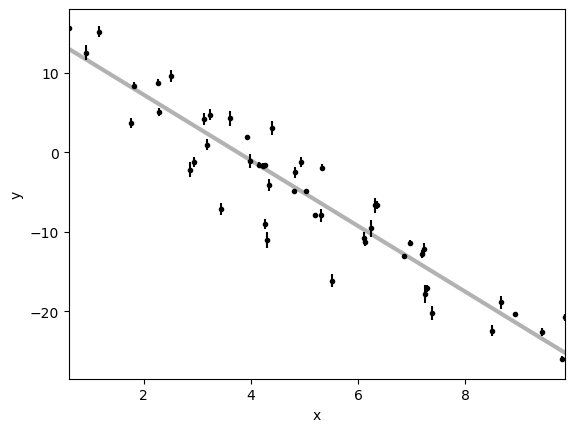

In [1]:
import numpy as np
import matplotlib.pyplot as plt

'''
Creating fake linear regression data, with the true
fit denoted by the thick grey line
'''

np.random.seed(123) # --> same set of random numbers appear every time.

# Choose the "true" parameters --> thick grey line in graph.
m_true = -4.123 
b_true = 15.456
f_true = 5.534 # --> determines how spread our fake data is

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N)) # --> gives ordered N random variables between 0 and 10
yerr = 0.1 + 1 * np.random.rand(N) # --> random error values for data
y = np.random.normal(loc=m_true * x + b_true, scale=yerr*f_true, size=N) # --> normally randomised linear data points
y_true = m_true * x + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Linear Least Squares

Continuing with the method outlined in the link above, we can fit the least squares line of best fit to see how it compares with our true line. As we can see, the Least Squares (LS) line clearly doesn't follow the true line of best fit as well as it could.

Least-squares estimates:
m = -4.250 ± 0.024
b = 16.430 ± 0.135


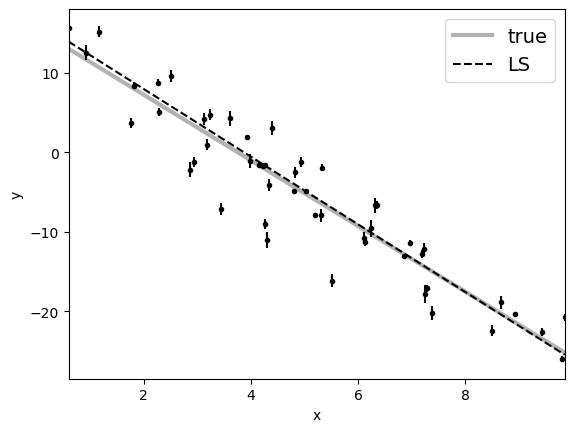

In [2]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3, label="true")
plt.plot(x, np.dot(np.vander(x, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y");

## Gradient Descent

https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent

https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931


The process of minimizing the loss is called **Gradient Descent**. It works in a similar way to the *Least Squares as a Maximum Likelihood Estimator* from the Stats notes; however in this case use something called the ***Loss Function***.

$$ \frac{1}{N} \sum_{i=0}^N \left(y_i - (m x_i + b) \right)^2 $$

where *N* is the number of points in our data set, *m* is our current gradient guess, and *b* is our current intercept guess.

To minimise we need to make the partial derivatives as small as possible. The partial derivative wrt *b* is:

$$ -\frac{2}{N} \sum_{i=0}^N \left(y_i - (m x_i + b) \right) $$

Now in order to make *b* converge on the optimal values, we first need to calculate what the gradient of *b* currently is.

In [3]:
def get_gradient_at_b(x, y, b, m):
    ''' 
    Finds the partial derivative of the 
    loss function wrt b at that point and 
    returns b_gradient
    '''    
    N = len(x)
    diff = 0
    for i in range(N):
        x_val = x[i]
        y_val = y[i]
        diff += (y_val - ((m * x_val) + b))
    b_gradient = -(2/N) * diff  
    return b_gradient

Similarly, to find the gradient at *m* we take the partial derivative of the loss function wrt *m* to obtain:

$$ -\frac{2}{N} \sum_{i=0}^N x_i\left(y_i - (m x_i + b) \right) $$

In [4]:
def get_gradient_at_m(x, y, b, m):
    ''' 
    Finds the partial derivative of the 
    loss function wrt m at that point and 
    returns m_gradient
    '''
    N = len(x)
    diff = 0
    for i in range(N):
        x_val = x[i]
        y_val = y[i]
        diff += x_val * (y_val - ((m * x_val) + b))
    m_gradient = -(2/N) * diff  
    return m_gradient

Now the plan is to iterate down the gradient to find the values of *b* and *m* such that they are minimised, but we don't want to move them so much that we overstep the minimum point. We can set the scale of the movement, which is called the **learning rate**. A learning rate too big might never converge, and a rate too small might take too long! First we create a function which moves one-step closer to our optimal values. Then we create a function which iterates through *num_iterations* times, until we get our desired output.

In [5]:
def step_gradient(b_current, m_current, x, y, learning_rate):
    '''
    Takes current variables and returns values for
    b and m which are 1 step closer to the optimal
    values
    '''
    
    # current (b,m) gradient, which we need to move closer to the minimum.
    b_gradient = get_gradient_at_b(x, y, b_current, m_current)
    m_gradient = get_gradient_at_m(x, y, b_current, m_current)
    
    # moving the values closer to minimum
    b = b_current - (learning_rate * b_gradient)
    m = m_current - (learning_rate * m_gradient)
    return [b, m]

'''*********************************************************************'''

def gradient_descent(x,y,learning_rate,num_iterations):
    ''' 
    Uses step_gradient() many times to converge on the
    optimal parameters
    '''
    # initial guess
    b = 0
    m = 0
    for i in range(num_iterations):
        b, m = step_gradient(b, m, x, y, learning_rate)
    return [b,m]

Now, using this function with the data we had before:

14.678105685223391 -4.021571861628898
15.456 -4.123


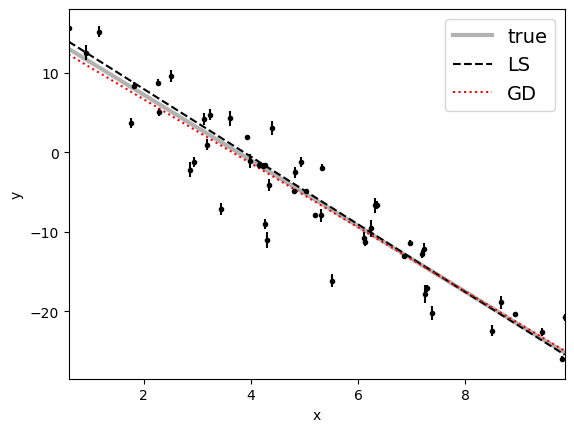

In [6]:
''' Including our Gradient Descent '''
b_gd, m_gd = gradient_descent(x, y, 0.01, 1000)
y_gd = (m_gd * x) + b_gd

print(b_gd, m_gd)
print(b_true, m_true)

''' Plotting '''
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3, label='true')
plt.plot(x, np.dot(np.vander(x, 2), w), "--k", label="LS")
plt.plot(x, y_gd, 'r:', label='GD')
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y");

Now when we look at our graph we see that the **Gradient Descent** creates a much better fitting line than the **Least Squares** method. There is a simpler way of obtaining the same result as the gradient descent. 

## Maximum Likelihood Estimation

A different MLE technique. We want to find the log of the likelihood and *minimise* it to find the correct model to use.

$$ \ln{ p(y|x,\sigma,m,b,f)} = - \frac{1}{2} \sum_n \left[\frac{(y_n - m x_n - b)^2}{s_n^2} + \ln(2 \pi s_n^2) \right] $$
$$ s_n^2 = \sigma_n^2 + f^2(m x_n + b)^2 $$



In [7]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

From here we use the *scipy.optimize* module to find the best fit of this function

True parameters:
m = -4.123 b = 15.456 f = 5.534

Least Squares estimates:
m = -4.250 ± 0.024 b = 16.430 ± 0.135

Gradient Descent estimates:
m = -4.022 b = 14.678

Maximum likelihood estimates:
m = -3.972 b = 15.015 f = 1.425



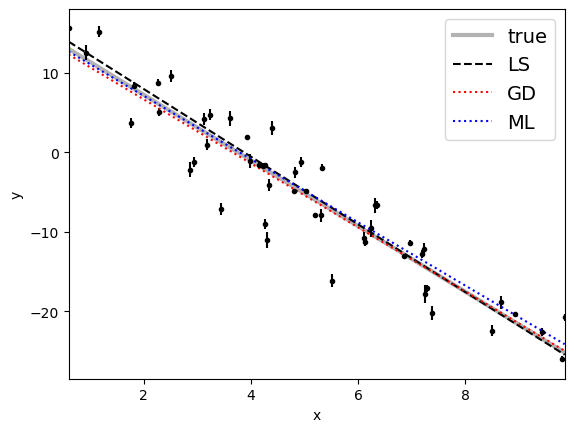

In [8]:
from scipy.optimize import minimize
np.random.seed(42) # For some reason this only works with this particular seed
nll = lambda *args: -log_likelihood(*args) 
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("True parameters:")
print("m = {0:.3f}".format(m_true), "b = {0:.3f}".format(b_true),"f = {0:.3f}".format(f_true))
print()
print("Least Squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])), "b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))
print()
print("Gradient Descent estimates:")
print("m = {0:.3f}".format(m_gd), "b = {0:.3f}".format(b_gd))
print()
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml), "b = {0:.3f}".format(b_ml),"f = {0:.3f}".format(np.exp(log_f_ml)))
print()

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3, label="true")
plt.plot(x, np.dot(np.vander(x, 2), w), "--k", label="LS")
plt.plot(x, y_gd, 'r:', label='GD')
plt.plot(x, np.dot(np.vander(x, 2), [m_ml, b_ml]), ":b", label="ML")
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y");

# Scikit-Learn

[-4.10267505]


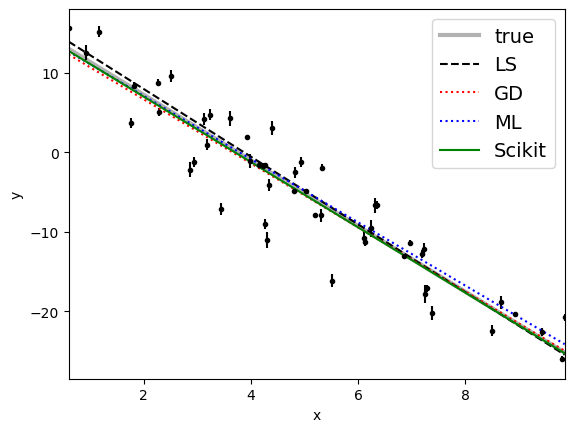

In [9]:
from sklearn.linear_model import LinearRegression

line_fitter = LinearRegression()
line_fitter.fit(x.reshape(-1,1), y)
skl_predict = line_fitter.predict(x.reshape(-1,1))
print(line_fitter.coef_)
#        NOTE
#We need to reshape x for scikit to work


plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3, label="true")
plt.plot(x, np.dot(np.vander(x, 2), w), "--k", label="LS")
plt.plot(x, y_gd, 'r:', label='GD')
plt.plot(x, np.dot(np.vander(x, 2), [m_ml, b_ml]), ":b", label="ML")
plt.plot(x, skl_predict, 'g', label='Scikit')
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y");

## Marginalization & uncertainty estimation

We want to find an estimate of the *posterior probability function*. **MCMC** (Markov chain Monte Carlo) creates samples from a continuous random variably, with a probability density $\propto$ a known function. These samples can be used to evaluate an integral over that variable, as its expected value or variance. https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

The ***posterior probability function*** $$ p(m,b,f | x,y,\sigma) \propto p(m,b,f) p(y|x,\sigma,m,b,f) $$

where $p(y|x,\sigma,m,b,f)$ is the *liklihood*, and $p(m,b,f)$ is the *prior*. We must write down priors if using MCMC, and we cannot draw parameter samples from the liklihood function.

In this instance the priors are: 
$$ p(m) = \begin{cases}
    1/5.5, & \text{if -6 < m < 1/2}\\
    0, & \text{otherwise}
  \end{cases}$$

In [10]:
def log_prior(theta):
    m, b, log_f = theta
    if -6.0 < m < 10.5 and 5.0 < b < 35.0 and -5.0 < log_f < 2.0:
        return 0.0
    return -np.inf

In [11]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [12]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(32, 3) # using the MLE model
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:09<00:00, 1086.56it/s]


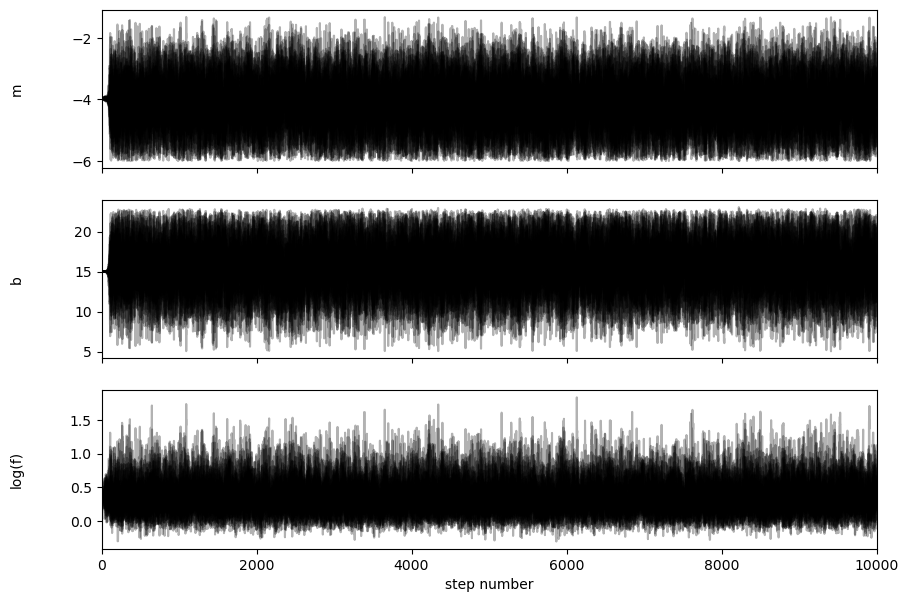

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. After fewer than 50 steps, the samples seem pretty well “burnt-in”.

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

# Tells us roughly how many steps are needed for the chain to 
# forget where it started

[41.92363512 41.63778781 40.62344322]


In [ ]:
flat_samples = sampler.get_chain(discard=500, thin=20, flat=True)
print(flat_samples.shape)

(15200, 3)


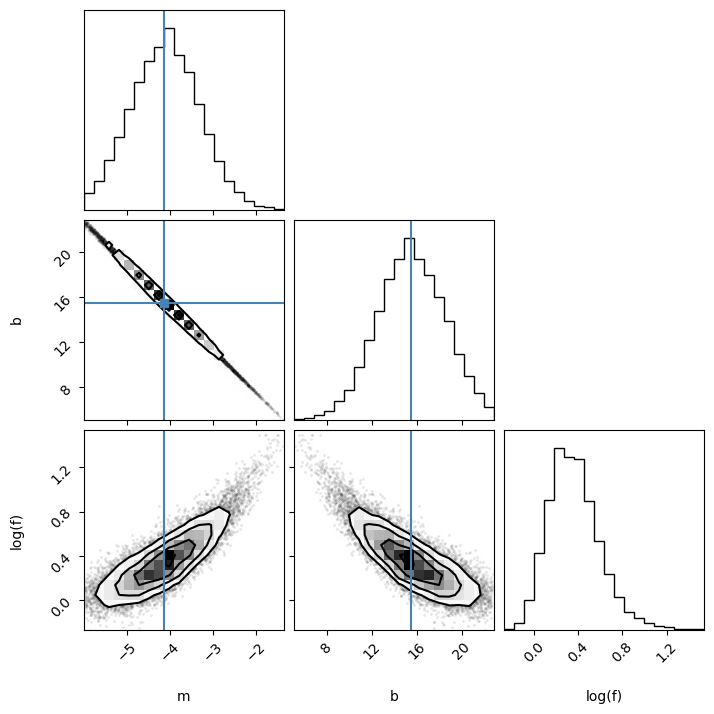

In [19]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

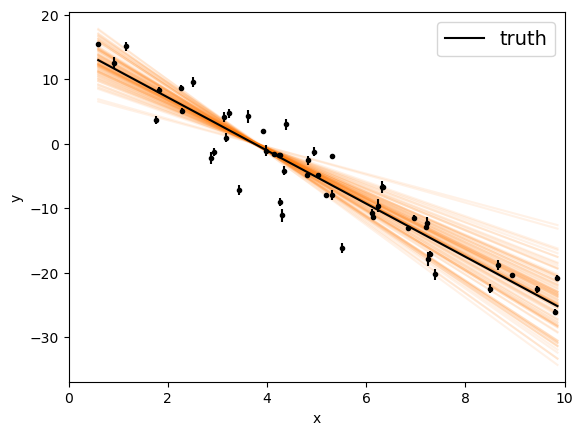

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");